# National-level analysis: Figures 1 & 4

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy.integrate as integrate
# from statsmodels.distributions.empirical_distribution import ECDF
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Figure 1

In [2]:
# Read in GMFD data
gmfd = pd.read_csv('../../data/yield/GMFD/all_gmfd_historical.csv')
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)

In [3]:
# Read in NEX models
nex_models = !ls ../../data/yield/NEX-GDDP/hist
nex = {model.replace("all_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/yield/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("all_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX yields
nex_yield = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['yield'] for model in nex_models}).dropna()
nex_yield = nex_yield.reset_index()
nex_yield["fips"] = nex_yield["fips"].astype(str).str.zfill(5)
nex_yield.set_index(['fips','year'], inplace=True)

In [4]:
# Read in CMIP models
cmip_models = !ls ../../data/yield/CMIP/hist
cmip = {model.replace("all_","").replace("_historical","").replace(".csv","") : pd.read_csv("../../data/yield/CMIP/hist/" + model) for model in cmip_models}
cmip_models = [model.replace("all_","").replace("_historical","").replace(".csv","") for model in cmip_models]

# CMIP yields
cmip_yield = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['yield'] for model in cmip_models}).dropna()
cmip_yield = cmip_yield.reset_index()
cmip_yield["fips"] = cmip_yield["fips"].astype(str).str.zfill(5)
cmip_yield.set_index(['fips','year'], inplace=True)

In [5]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [13]:
# Yield (weighted by production)

# NEX
nex_weighted = pd.merge(nex_yield.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['year']).sum()
nex_weighted = nex_weighted.apply(lambda x: x/x['national_weight'], axis=1)
nex_weighted.drop(columns='national_weight', inplace=True)

# CMIP
cmip_weighted = pd.merge(cmip_yield.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['year']).sum()
cmip_weighted = cmip_weighted.apply(lambda x: x/x['national_weight'], axis=1)
cmip_weighted.drop(columns='national_weight', inplace=True)

# GMFD
gmfd_weighted = pd.merge(gmfd[['fips','year', 'log_yield_sim']], weights.reset_index(), on = ['fips','year'], how = 'inner')
gmfd_weighted['log_yield_sim'] = gmfd_weighted['log_yield_sim'] * gmfd_weighted['national_weight']
gmfd_weighted = gmfd_weighted.groupby(['year']).sum()
gmfd_weighted = gmfd_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weighted.drop(columns='national_weight', inplace=True)

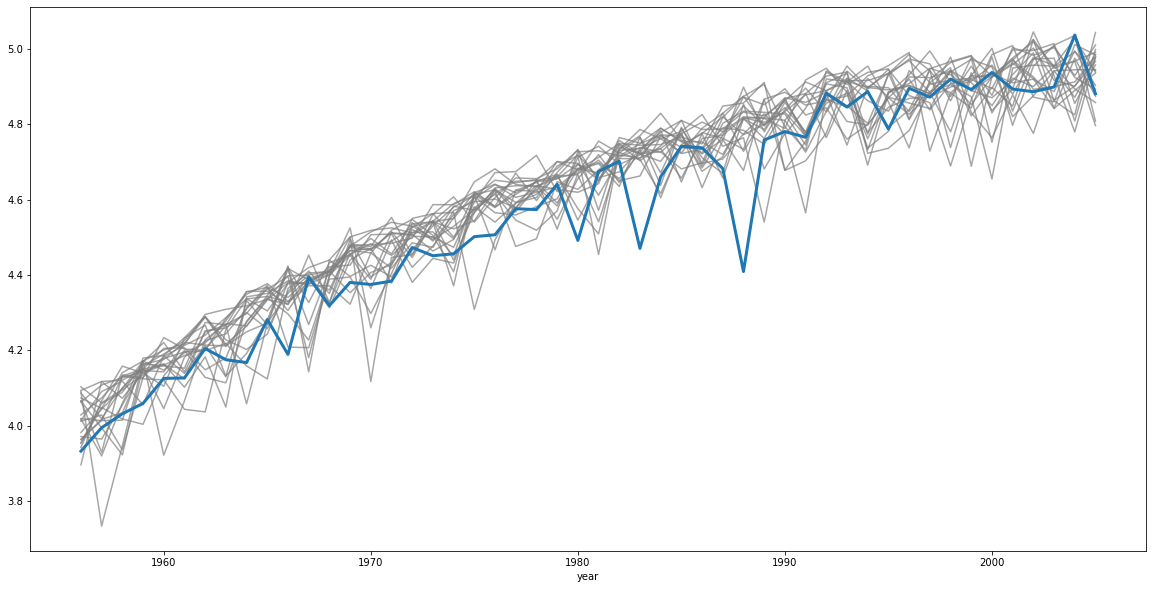

In [20]:
fig,ax = plt.subplots(1,1, figsize=(20,10))

nex_weighted.plot(ax=ax, color='gray', alpha=0.7, legend=None)
# cmip_weighted.plot(ax=ax, color='gray', alpha=0.7, legend=None)
gmfd_weighted.plot(ax=ax, lw=3, legend=None)

plt.show()

## Figure 1

In [16]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [17]:
##################################################################################################
include_p05 = False ################# If True, only counties with F-test p-value < 0.05 are included
include_loo = True ################# If True, only counties with LOO CV improvement are included
if include_p05:
    p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
elif include_loo:
    p05_counties = pd.read_csv('../ag_model/fit_model/loo_yes.csv')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
##################################################################################################

# Yield (weighted by production)
nex_weighted = pd.merge(nex_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['Year']).sum()

cmip_weighted = pd.merge(cmip_hist.reset_index(), weights.reset_index(), left_on = ['GEOID','Year'], right_on = ['GEOID','year'], how = 'inner').drop(columns = ['year'])
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['Year']).sum()

# Ensembles
NEXens_w = nex_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
CMIPens_w = cmip_weighted.drop(columns = ['GMFD', 'national_weight']).to_numpy().flatten()
GMFDens_w = nex_weighted.filter(['GMFD']).to_numpy().flatten()

In [18]:
%%time
# Construct CDFs
nexgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_w), 3*silverman(NEXens_w), 30)})
cmipgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_w), 3*silverman(CMIPens_w), 30)})
nexgrid.fit(NEXens_w[:, None])
cmipgrid.fit(CMIPens_w[:, None])
print(nexgrid.best_params_['bandwidth'])
print(cmipgrid.best_params_['bandwidth'])
NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth'])
NEX_ens_pdf.fit(NEXens_w[:, np.newaxis]);
CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth'])
CMIP_ens_pdf.fit(CMIPens_w[:, np.newaxis]);

0.01909519300964212
0.03568534176614341
CPU times: user 2.3 s, sys: 5.89 ms, total: 2.31 s
Wall time: 2.32 s


KernelDensity(bandwidth=0.03568534176614341)

In [19]:
%%time
sampDist = [NEX_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]
CsampDist = [CMIP_ens_pdf.sample(n_samples = 46).flatten() for i in range(50000)]

CPU times: user 3.68 s, sys: 36.1 ms, total: 3.72 s
Wall time: 3.73 s


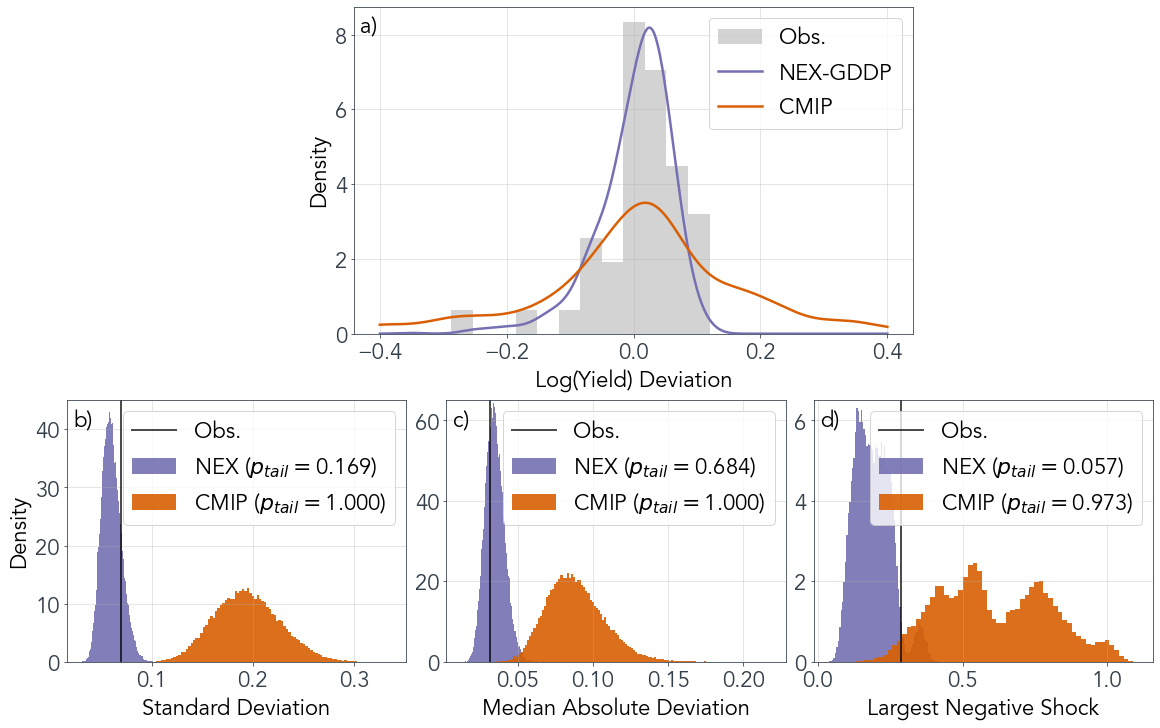

In [31]:
# Final
fig = plt.figure(figsize=(16,10), constrained_layout=True)
gs = gridspec.GridSpec(9, 9, figure=fig)
plt.rcParams['font.size'] = 22

# PDF
ax1 = fig.add_subplot(gs[:5,2:-2])
xarr = np.linspace(-0.4,0.4,1000)
ax1.hist(GMFDens_w, label = 'Obs.', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax1.plot(xarr, np.exp(NEX_ens_pdf.score_samples(xarr[:,None])), label = 'NEX-GDDP', color = '#7570b3', linewidth=2.5)
ax1.plot(xarr, np.exp(CMIP_ens_pdf.score_samples(xarr[:,None])), label = 'CMIP', color = '#d95f02', linewidth=2.5)

handles, labels = ax1.get_legend_handles_labels()
order = [2,0,1]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax1.set_xlabel('Log(Yield) Deviation')
ax1.set_ylabel('Density')
ax1.text(0.01, 0.92, 'a)', transform=ax1.transAxes)
ax1.grid(zorder=10, alpha=0.4)

# SD
ax2 = fig.add_subplot(gs[-4:, :3])
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax2.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax2.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax2.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax2.set_xlabel('Standard Deviation')
ax2.set_ylabel('Density')
ax2.text(0.02, 0.9, 'b)', transform=ax2.transAxes)
ax2.legend()
ax2.grid(zorder=10, alpha=0.4)
ax2.set_ylim([0,45])

# MAD
ax3 = fig.add_subplot(gs[-4:, 3:6])
sampDist1 = np.array([ss.median_abs_deviation(x) for x in sampDist])
CsampDist1 = np.array([ss.median_abs_deviation(x) for x in CsampDist])
val = ss.median_abs_deviation(GMFDens_w)
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax3.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax3.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax3.plot([val,val], [0,80], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax3.set_xlabel('Median Absolute Deviation')
ax3.text(0.02, 0.9, 'c)', transform=ax3.transAxes)
ax3.legend()
ax3.grid(zorder=10, alpha=0.4)
ax3.set_ylim([0,65])

# Min
ax4 = fig.add_subplot(gs[-4:, 6:])
sampDist1 = np.array([np.abs(np.min(x)) for x in sampDist])
CsampDist1 = np.array([np.abs(np.min(x)) for x in CsampDist])
val = np.abs(np.min(GMFDens_w))
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)

ax4.hist(sampDist1, density=True,  label = 'NEX ($p_{tail}=$%0.3f)' % (1-nex_ecdf(val)), color = '#7570b3', alpha = 0.9, bins='auto')
ax4.hist(CsampDist1, density=True, label = 'CMIP ($p_{tail}=$%0.3f)' % (1-cmip_ecdf(val)), color = '#d95f02', alpha = 0.9, bins='auto')
ax4.plot([val,val], [0,10], linewidth=2, color = 'black', label = 'Obs.', alpha=0.7)
ax4.set_xlabel('Largest Negative Shock')
ax4.text(0.02, 0.9, 'd)', transform=ax4.transAxes)
ax4.legend()
ax4.set_xticks([0.0,0.5,1.0])
ax4.grid(zorder=0, alpha=0.4)
ax4.set_ylim([0,6.5])

# Save
# plt.show()
plt.savefig('../figs/figure1.pdf')

## Figure 4

In [21]:
# Get both ensembles
from combine import combine_nex_yield, combine_cmip_yield

nex_mid = combine_nex_yield(hist=False, mid=True)
cmip_mid = combine_cmip_yield(hist=False, mid=True)

nex_end = combine_nex_yield(hist=False, end=True)
cmip_end = combine_cmip_yield(hist=False, end=True)

In [22]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../usda/output/USDA_county_yields_w_county_quad_trends.csv').filter(["GEOID", "year", "area","yield"])
weights["GEOID"] = weights["GEOID"].astype(str).str.zfill(5)
weights.sort_values(by = ['GEOID', 'year'], inplace = True)
weights.set_index(['GEOID', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])

# Take mean for projections
weights = weights.mean(level = 'GEOID')

In [23]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [24]:
##################################################################################################
include_p05 = False ################# If True, only counties with F-test p-value < 0.05 are included
include_loo = True ################# If True, only counties with LOO CV improvement are included
if include_p05:
    p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
elif include_loo:
    p05_counties = pd.read_csv('../ag_model/fit_model/loo_yes.csv')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
##################################################################################################

# Yield (weighted by production)
nex_mid_weighted = pd.merge(nex_mid.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in nex_mid_weighted.columns[2:-1]:
    nex_mid_weighted[model] = nex_mid_weighted[model] * nex_mid_weighted['national_weight']
nex_mid_weighted = nex_mid_weighted.groupby(['Year']).sum()

cmip_mid_weighted = pd.merge(cmip_mid.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in cmip_mid_weighted.columns[2:-1]:
    cmip_mid_weighted[model] = cmip_mid_weighted[model] * cmip_mid_weighted['national_weight']
cmip_mid_weighted = cmip_mid_weighted.groupby(['Year']).sum()

nex_end_weighted = pd.merge(nex_end.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in nex_end_weighted.columns[2:-1]:
    nex_end_weighted[model] = nex_end_weighted[model] * nex_end_weighted['national_weight']
nex_end_weighted = nex_end_weighted.groupby(['Year']).sum()

cmip_end_weighted = pd.merge(cmip_end.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in cmip_end_weighted.columns[2:-1]:
    cmip_end_weighted[model] = cmip_end_weighted[model] * cmip_end_weighted['national_weight']
cmip_end_weighted = cmip_end_weighted.groupby(['Year']).sum()

# Ensembles
NEXens_mid_w = nex_mid_weighted.drop(columns = ['national_weight']).to_numpy().flatten()
CMIPens_mid_w = cmip_mid_weighted.drop(columns = ['national_weight']).to_numpy().flatten()
NEXens_end_w = nex_end_weighted.drop(columns = ['national_weight']).to_numpy().flatten()
CMIPens_end_w = cmip_end_weighted.drop(columns = ['national_weight']).to_numpy().flatten()

In [25]:
%%time
# Construct CDFs
nexmidgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_mid_w), 3*silverman(NEXens_mid_w), 30)})
cmipmidgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_mid_w), 3*silverman(CMIPens_mid_w), 30)})
nexendgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_end_w), 3*silverman(NEXens_end_w), 30)})
cmipendgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_end_w), 3*silverman(NEXens_end_w), 30)})

nexmidgrid.fit(NEXens_mid_w[:, None])
cmipmidgrid.fit(CMIPens_mid_w[:, None])
nexendgrid.fit(NEXens_end_w[:, None])
cmipendgrid.fit(CMIPens_end_w[:, None])

print(nexmidgrid.best_params_['bandwidth'])
print(cmipmidgrid.best_params_['bandwidth'])
print(nexendgrid.best_params_['bandwidth'])
print(cmipendgrid.best_params_['bandwidth'])

NEX_ens_mid_pdf = KernelDensity(bandwidth=nexmidgrid.best_params_['bandwidth'])
NEX_ens_mid_pdf.fit(NEXens_mid_w[:, np.newaxis]);
CMIP_ens_mid_pdf = KernelDensity(bandwidth=cmipmidgrid.best_params_['bandwidth'])
CMIP_ens_mid_pdf.fit(CMIPens_mid_w[:, np.newaxis]);
NEX_ens_end_pdf = KernelDensity(bandwidth=nexendgrid.best_params_['bandwidth'])
NEX_ens_end_pdf.fit(NEXens_end_w[:, np.newaxis]);
CMIP_ens_end_pdf = KernelDensity(bandwidth=cmipendgrid.best_params_['bandwidth'])
CMIP_ens_end_pdf.fit(CMIPens_end_w[:, np.newaxis]);

0.09156052542919565
0.08150078228433406
0.13206744314259064
0.1488975139244788
CPU times: user 1.19 s, sys: 7.12 ms, total: 1.2 s
Wall time: 1.2 s


KernelDensity(bandwidth=0.1488975139244788)

In [26]:
# Get return periods
logyields = [i for i in np.linspace(-0.6,0,50)]
NEXr_mid = []
NEXr_end = []
CMIPr_mid = []
CMIPr_end = []
for logyield in logyields:
    xgrid = np.linspace(-10,logyield,1000)
    nexr_mid = 1/integrate.trapz(np.exp(NEX_ens_mid_pdf.score_samples(xgrid[:,None])), xgrid)
    nexr_end = 1/integrate.trapz(np.exp(NEX_ens_end_pdf.score_samples(xgrid[:,None])), xgrid)
    cmipr_mid = 1/integrate.trapz(np.exp(CMIP_ens_mid_pdf.score_samples(xgrid[:,None])), xgrid)
    cmipr_end = 1/integrate.trapz(np.exp(CMIP_ens_end_pdf.score_samples(xgrid[:,None])), xgrid)
    
    NEXr_mid.append(nexr_mid)
    NEXr_end.append(nexr_end)
    CMIPr_mid.append(cmipr_mid)
    CMIPr_end.append(cmipr_end)

In [27]:
# Largest yield shock
GMFDens_w.min()

-0.28757724332232504

In [28]:
# Closest value
logyields[-25]

-0.29387755102040813

In [29]:
# Projected return periods
[NEXr_mid[-25],NEXr_end[-25],CMIPr_mid[-25],CMIPr_end[-25]]

[15.982981491835512, 6.7013332898907825, 6.451760115672035, 4.5646934772537495]

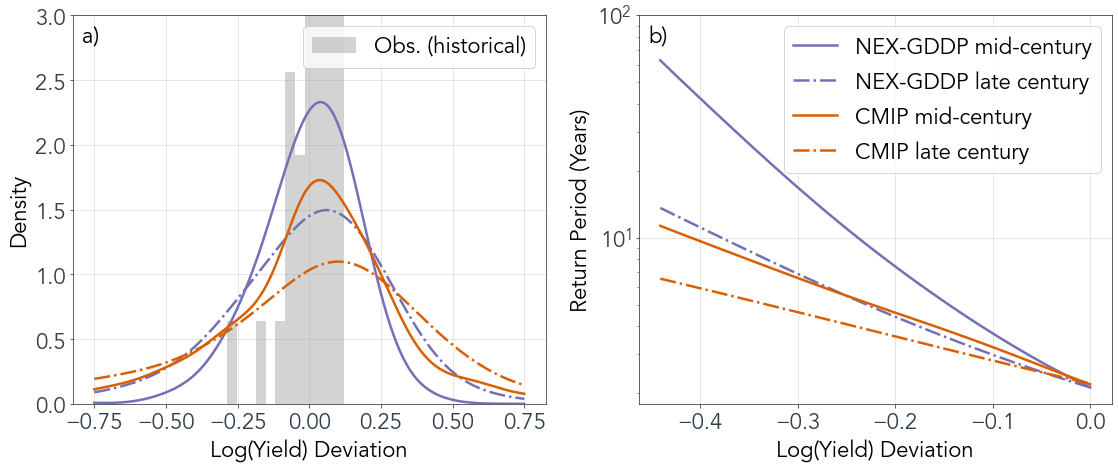

In [30]:
# Plot all
fig, axs = plt.subplots(1,2,figsize = (16,7))
plt.rcParams['font.size'] = 22

# Distributions
ax = axs[0]
xarr = np.linspace(-0.75,0.75,1000)
ax.plot(xarr, np.exp(NEX_ens_mid_pdf.score_samples(xarr[:,None])), color = '#7570b3', linewidth=2.5)
ax.plot(xarr, np.exp(NEX_ens_end_pdf.score_samples(xarr[:,None])), color = '#7570b3', linewidth=2.5, linestyle='dashdot' )

ax.plot(xarr, np.exp(CMIP_ens_mid_pdf.score_samples(xarr[:,None])), color = '#d95f02', linewidth=2.5)
ax.plot(xarr, np.exp(CMIP_ens_end_pdf.score_samples(xarr[:,None])), color = '#d95f02', linewidth=2.5, linestyle='dashdot')

ax.hist(GMFDens_w, label = 'Obs. (historical)', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax.set_ylim([0,3])

ax.legend(loc = 'upper right')
ax.set_xlabel('Log(Yield) Deviation')
ax.set_ylabel('Density')
ax.grid(zorder=10, alpha=0.4)
ax.text(0.02, 0.93, 'a)', transform=ax.transAxes)

# Return Periods
ax=axs[1]
n=13
ax.plot(logyields[n:], NEXr_mid[n:], label = 'NEX-GDDP mid-century', color = '#7570b3', linewidth=2.5)
ax.plot(logyields[n:], NEXr_end[n:], label = 'NEX-GDDP late century', color = '#7570b3', linewidth=2.5, linestyle='dashdot' )

ax.plot(logyields[n:], CMIPr_mid[n:], label = 'CMIP mid-century', color = '#d95f02', linewidth=2.5)
ax.plot(logyields[n:], CMIPr_end[n:], label = 'CMIP late century', color = '#d95f02', linewidth=2.5, linestyle='dashdot')

ax.legend()
ax.set_xlabel('Log(Yield) Deviation')
ax.set_ylabel('Return Period (Years)')
ax.set_yscale('log')
ax.set_yticks([10, 100])
ax.grid(zorder=10, alpha=0.4)
ax.text(0.02, 0.93, 'b)', transform=ax.transAxes)

plt.tight_layout()
# plt.show()
plt.savefig('../figs/figure4.pdf')